Make virtual environment: python -m venv <kernelname>

To start virtual environment in terminal: .\<kernelname>\Scripts\activate
or conda create -n <kernelname> python=<pythonversion>


Tensorflow CPU: python 3.12.5

Tensorflow GPU: python 3.10.15


Adding virtual environment to jupyter notebook:
python -m ipykernel install --name=<kernelname>

In [ ]:
!pip install tensorflow ipykernel opencv-python matplotlib

In [1]:
!pip list

Package                 Version
----------------------- -----------
absl-py                 2.1.0
asttokens               2.4.1
astunparse              1.6.3
certifi                 2024.8.30
charset-normalizer      3.3.2
colorama                0.4.6
comm                    0.2.2
contourpy               1.3.0
cycler                  0.12.1
debugpy                 1.8.6
decorator               5.1.1
executing               2.1.0
flatbuffers             24.3.25
fonttools               4.54.1
gast                    0.6.0
google-pasta            0.2.0
grpcio                  1.66.2
h5py                    3.12.1
idna                    3.10
ipykernel               6.29.5
ipython                 8.28.0
jedi                    0.19.1
jupyter_client          8.6.3
jupyter_core            5.7.2
keras                   3.5.0
kiwisolver              1.4.7
libclang                18.1.1
Markdown                3.7
markdown-it-py          3.0.0
MarkupSafe              2.1.5
matplotlib           

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.config.list_physical_devices('GPU'))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))


[]
tf.Tensor(-1211.5432, shape=(), dtype=float32)


In [3]:
#get image count from folders
dirs = os.listdir("data")
total = 0
for dir in dirs:
    files = list(os.listdir("Data/"+dir))
    total+=len(files)
    print(dir + " directory has " + str(len(files)) + " images")
print("Total images: " + str(total))

happy directory has 153 images
sad directory has 152 images
Total images: 305


In [4]:
#Load images into array as dataset
base_dir = "data/"
img_size = 180
batch = 32

full_dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=0,
    batch_size=batch,
    image_size=(img_size, img_size)
)

class_names = full_dataset.class_names
total_size = len(full_dataset)

train_size = int(total_size * 0.7)   # 70% for training
val_size = int(total_size * 0.2)     # 20% for validation
test_size = total_size - train_size - val_size # 10% for test

# Split the dataset into train, validation, and test sets
train_ds = full_dataset.take(train_size)
validation_ds = full_dataset.skip(train_size).take(val_size)
test_ds = full_dataset.skip(train_size + val_size).take(test_size)

print(f'Train dataset size: {train_size}')
print(f'Validation dataset size: {val_size}')
print(f'Test dataset size: {test_size}')
print(class_names)


Found 305 files belonging to 2 classes.
Train dataset size: 7
Validation dataset size: 2
Test dataset size: 1
['happy', 'sad']


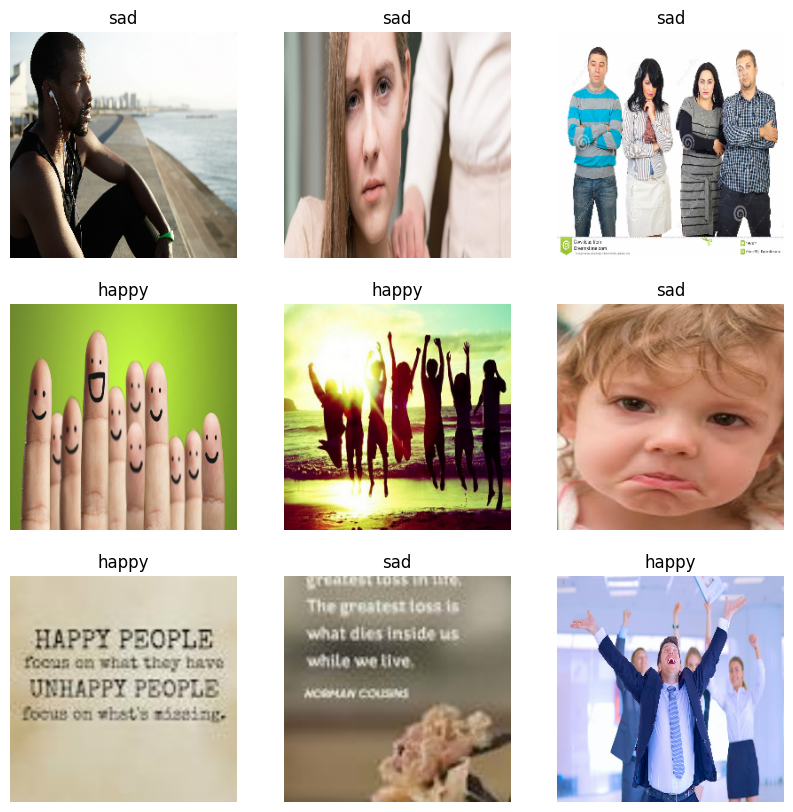

In [5]:
def displayImages(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Fetch one batch of images and labels
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots, i+1 is the column to put the image since plt starts at 1
            plt.imshow(images[i].numpy().astype('uint8'))  # Display the image
            plt.title(class_names[labels[i]])  # Set the title to the corresponding dish name
            plt.axis('off')  # Hide the axes
    plt.show() 
displayImages(train_ds, class_names)


In [6]:
#Caching data to improve loading and processing of data
AUTOTUNE = tf.data.AUTOTUNE  #allow TensorFlow to decide the optimal buffer size for prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) #Caches the dataset in memory after the first epoch, so subsequent epochs can access it without reloading.
validation_ds = validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

c:\Users\incre\OneDrive\Documents\Dish-Classifier-ML\imageclassification\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


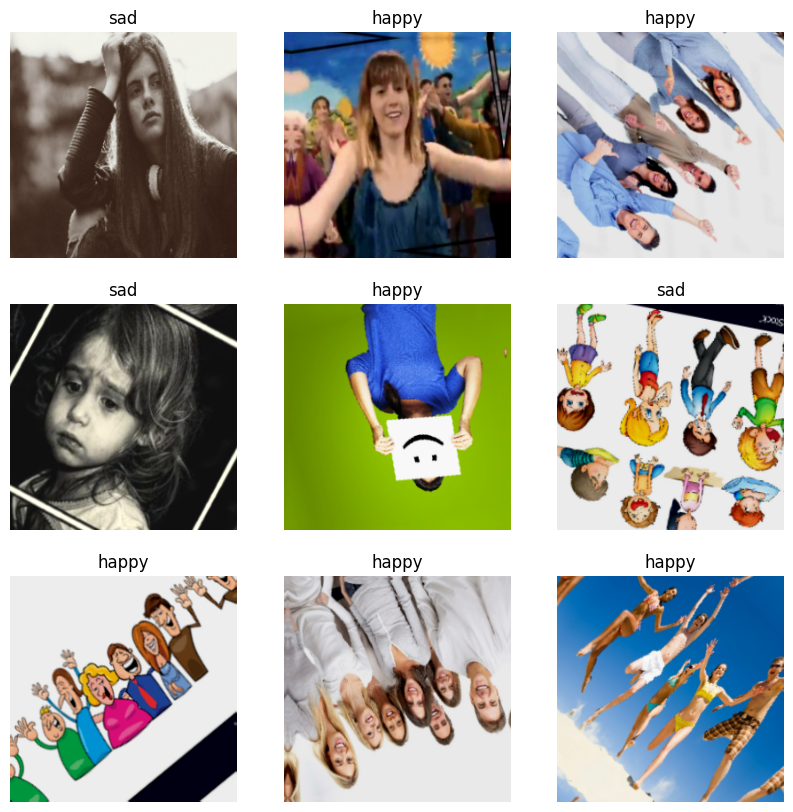

In [7]:
#Data Augmentation
#Increasing the size of dataset by randomly modifying existing images. Helps model learn better by providing diverse examples
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

def display_augmented_images(dataset, data_augmentation, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Fetch one batch of images and labels
        augmented_images = data_augmentation(images)  # Apply augmentation to the images
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots
            plt.imshow(augmented_images[i].numpy().astype('uint8'))  # Display the augmented image
            plt.title(class_names[labels[i]])  # Set the title to the corresponding dish name
            plt.axis('off') 
    plt.show()

display_augmented_images(train_ds, data_augmentation, class_names)

In [26]:
#Model Creation

'''
Conv2D: 
    - Filters: 32 to detect 16 different patterns, 
    - Kernel size: 3 which slides across the image and looks at every 3x3 block of pixels to extract features
    - padding: "same" which adds padding around the image so that the output of this layer has the same height and width as the input
MaxPooling2D:
    Reduces the size of the image and focuses on important features


NOTES:
    - include dropout layer if model is overfitting
'''
model = Sequential([
    #data_augmentation, #First layer, used to randomly transform images during training to create more diverse samples
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)), #Every image has rgb colors ranging from 0-255, rescale to between 0 and 1
    Conv2D(16, 3, padding="same", activation="relu"), #Not providing input in first layer because we're reading the data 
    MaxPooling2D(),  
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation="relu"),
    Dense(len(class_names)) 
])

In [27]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    16,777,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,801,570 (64.09 MB)

 Trainable params: 16,801,570 (64.09 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train_ds, epochs=20, validation_data=validation_ds, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 962ms/step - accuracy: 0.5079 - loss: 4.2667 - val_accuracy: 0.4688 - val_loss: 0.9864
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 657ms/step - accuracy: 0.5293 - loss: 0.7956 - val_accuracy: 0.6094 - val_loss: 0.6743
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 626ms/step - accuracy: 0.5514 - loss: 0.6697 - val_accuracy: 0.6562 - val_loss: 0.6243
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 628ms/step - accuracy: 0.5737 - loss: 0.6421 - val_accuracy: 0.6562 - val_loss: 0.6068
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.6734 - loss: 0.5770 - val_accuracy: 0.7344 - val_loss: 0.5169
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 580ms/step - accuracy: 0.7465 - loss: 0.5259 - val_accuracy: 0.7188 - val_loss: 0.5163
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 578ms/step - accuracy: 0.7148 - loss: 0.5078 - val_accuracy: 0.8594 - val_loss: 0.4289
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 604ms/step - accuracy: 0.8492 - loss: 0.4018 - val_accuracy: 0.8438 - val_loss:

# Plot Performance

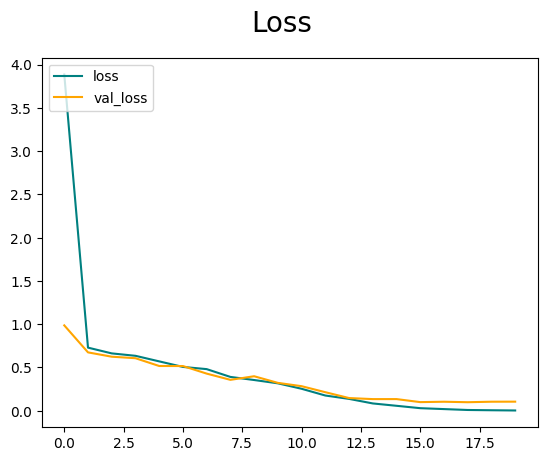

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

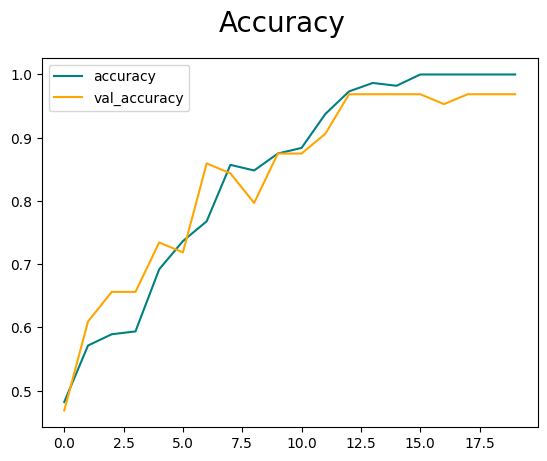

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Testing model


In [31]:
import cv2

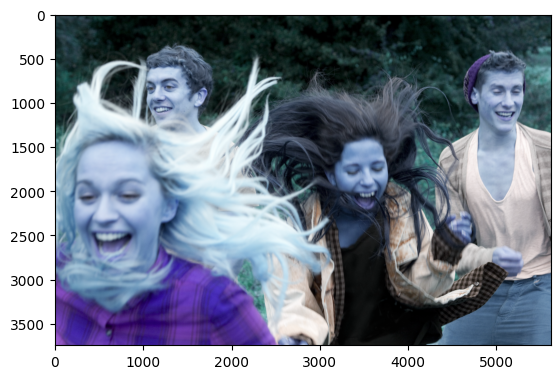

In [32]:
img = cv2.imread("154006829.jpg")
plt.imshow(img)
plt.show()


In [33]:
def classifyImage(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_expand_dim = tf.expand_dims(input_image_array, 0)

    predictions = model.predict(input_image_expand_dim)
    result = tf.nn.softmax(predictions[0])

    predicted_class_index = np.argmax(result)
    predicted_class_name = class_names[predicted_class_index]
    confidence = result[predicted_class_index].numpy() * 100
    print(f"Predicted {predicted_class_name} with {confidence:.2f}% Confidence")
    return predicted_class_name

classifyImage("154006829.jpg")
classifyImage("8iAb9k4aT.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
Predicted happy with 99.98% Confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted sad with 99.01% Confidence


'sad'